We want to assemble the following tables:
- both should have columns: temperature, pressure, humidity, wind_speed, wind_direction, adjusted_mirror_temp, mirror_temp
- and predictor column: airtemp for the next obsday
- as well as variance

We want:
- One table with just mirror_cooling = 0 (off)
- One table with everything averaged per obsday

In [18]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats
import sys, os, warnings
import pandas as pd
from collections import Counter


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

In [3]:
# Open Files
tenmin_binned = Table(fitsio.read('../cleaned_dataset_10mins/outputs/full_cleaned_telemetry.fits'))
obsday_binned = Table(fitsio.read('../cleaned_dataset_10mins/outputs/with_adjusted_temp_cleaned_telemetry.fits'))

In [4]:
obsday_binned = obsday_binned.to_pandas()
obsday_binned.rename(columns={'Observing Day': 'obsday'}, inplace=True)
obsday_binned

,mirror_ready,airmass,temperature,pressure,humidity,wind_speed,wind_direction,dimm,dewpoint,mirror_avg_temp,mirror_desired_temp,mirror_temp,mirror_cooling,air_temp,air_flow,air_dewpoint,is_good_obsday,adjusted_desired_temp,obsday
0,0.538396,1.061356,21.040383,794.482495,33.492733,13.384589,293.937791,0.706829,4.305944,20.750439,20.00000,20.748057,0.454421,20.959426,0.301808,5.176106,False,20.0,2021-09-14
1,0.392268,1.061567,20.846477,793.885798,30.110657,10.325268,316.762562,0.631512,2.626580,20.340918,20.00000,20.340664,0.662218,21.838363,0.434008,3.907556,False,20.0,2021-09-15
2,0.282366,1.030588,21.453405,793.496934,33.679609,9.568663,169.116535,0.570527,4.582490,20.381954,19.95207,20.381133,0.601317,21.935603,0.393665,5.388895,False,18.0,2021-09-16
3,0.247408,1.157038,19.348314,796.483708,53.821591,5.919081,136.602343,0.575595,9.644918,18.590214,18.00000,18.581965,0.670060,20.452457,0.435760,9.120393,False,18.0,2021-09-17
4,0.463045,1.032370,18.124226,795.954992,77.304527,9.489310,174.769908,0.584200,13.974617,18.538034,18.00000,18.539266,0.607054,19.840065,0.407973,12.879209,False,18.0,2021-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,0.070875,1.063646,6.787604,795.000000,53.587232,15.043157,132.737188,0.000000,-2.131504,4.537478,-2.12500,4.543186,0.932275,7.790498,1.022485,-2.135874,False,4.0,2023-02-18
450,0.000000,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,0.000000,0.006532,6.631120,4.00000,6.631846,1.000000,7.350313,1.112473,-0.368080,True,4.0,2023-02-19
451,0.000000,1.000000,5.646588,790.502645,82.480356,12.207638,131.577236,0.000000,2.782820,7.122006,4.00000,7.122464,1.000000,7.895247,1.106747,1.709051,True,4.0,2023-02-20
452,0.000000,1.000000,1.518228,789.600867,99.280955,30.616651,173.433540,0.000000,1.410710,7.046642,4.00000,7.045948,1.000000,5.761747,1.086811,1.343647,True,4.0,2023-02-21


## Select columns for training

In [5]:
features = ['Binned Time','mirror_cooling','temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction', 'mirror_temp', 'air_temp']
tenmin = tenmin_binned[features]

# convert everything to pandas
tenmin = tenmin.to_pandas()

# Bin by Obsday

In [6]:
# add obsday column
tenmin['Binned Time'] = pd.to_datetime(tenmin['Binned Time'])
tenmin['Observing Day'] = tenmin['Binned Time'] - pd.Timedelta(hours=12)
tenmin['Observing Day'] = tenmin['Observing Day'].dt.floor('D') + pd.Timedelta(hours=12)

### Create the 24 hr Obsday averaged table:

In [7]:
# group by obsday and get means and variances
means = tenmin.groupby('Observing Day').mean()
variances = tenmin.groupby('Observing Day').var()

# join the means and variances together
full_day = means.join(variances, rsuffix='_var')
full_day

/tmp/ipykernel_1268067/2383183157.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = tenmin.groupby('Observing Day').mean()
/tmp/ipykernel_1268067/2383183157.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = tenmin.groupby('Observing Day').var()


,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var
Observing Day,,,,,,,,,,,,,,,,
2021-09-14 12:00:00,0.454421,21.040383,794.482495,33.492733,13.384589,293.937791,20.748057,20.959426,0.248248,0.538658,0.060309,5.823315,12.495317,170.664639,0.470389,0.137797
2021-09-15 12:00:00,0.662218,20.846477,793.885798,30.110657,10.325268,316.762562,20.340664,21.838363,0.222283,1.121938,0.864430,5.197696,7.223977,275.512328,0.263264,4.092305
2021-09-16 12:00:00,0.601317,21.453405,793.496934,33.679609,9.568663,169.116535,20.381133,21.935603,0.238845,2.896639,0.404218,33.033023,27.494060,4876.835674,0.276811,4.534386
2021-09-17 12:00:00,0.670060,19.348314,796.483708,53.821591,5.919081,136.602343,18.581965,20.452457,0.214482,0.617031,0.477390,43.390580,5.111971,6407.702694,0.468626,1.965519
2021-09-18 12:00:00,0.607054,18.124226,795.954992,77.304527,9.489310,174.769908,18.539266,19.840065,0.238509,1.130825,1.230947,87.270898,39.647019,5437.799939,0.347746,1.877360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-18 12:00:00,0.932275,6.787604,795.000000,53.587232,15.043157,132.737188,4.543186,7.790498,0.062277,2.864519,0.000000,56.212117,78.637620,756.692312,3.008891,2.613771
2023-02-19 12:00:00,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,6.631846,7.350313,0.000000,0.901035,1.342800,391.264808,65.742586,201.828787,0.094299,0.262968
2023-02-20 12:00:00,1.000000,5.646588,790.502645,82.480356,12.207638,131.577236,7.122464,7.895247,0.000000,0.788047,4.064194,98.904790,31.691739,2177.325295,0.051339,0.513966


### Create the nighttime only table:

In [8]:
# Filter out the nighttime only times (mirror cooling off)
mask = tenmin['mirror_cooling'] == 0
night_table = tenmin[mask]

In [9]:
# group by obsday and get means and variances
night_means = night_table.groupby('Observing Day').mean()
night_variances = night_table.groupby('Observing Day').var()

# join the means and variances together
nights = night_means.join(night_variances, rsuffix='_var')
nights

/tmp/ipykernel_1268067/3431044541.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  night_means = night_table.groupby('Observing Day').mean()
/tmp/ipykernel_1268067/3431044541.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  night_variances = night_table.groupby('Observing Day').var()


,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var
Observing Day,,,,,,,,,,,,,,,,
2021-09-14 12:00:00,0.0,21.428106,794.627577,33.480851,15.057432,295.359779,21.336994,21.220057,0.0,0.139429,0.053321,1.156037,9.476581,162.573864,0.025857,0.098644
2021-09-15 12:00:00,0.0,20.425639,793.378015,30.812723,12.495212,327.098737,20.982825,20.468132,0.0,0.233362,0.174859,5.370851,2.094271,53.677017,0.033440,0.406194
2021-09-16 12:00:00,0.0,20.328574,793.909419,37.961965,12.414629,180.969665,20.981847,20.885566,0.0,0.998596,0.169530,27.045090,15.587714,1825.807928,0.045910,2.567866
2021-09-17 12:00:00,0.0,19.071664,796.809246,58.912734,5.759092,179.334126,19.298272,19.664185,0.0,0.322514,0.102964,10.594951,3.685866,11047.234597,0.144000,1.447157
2021-09-18 12:00:00,0.0,17.148162,795.151934,87.064872,8.712749,206.923433,19.174730,18.631045,0.0,0.089296,0.286781,11.433838,36.139489,4748.717443,0.010605,0.132533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-09 12:00:00,0.0,4.754621,794.250370,14.550358,18.245627,173.843774,4.958309,4.822462,0.0,3.529415,0.403749,97.665015,38.807764,14415.911841,0.705289,1.526486
2023-02-10 12:00:00,0.0,8.916500,793.603787,7.497143,24.060184,112.156033,7.191246,8.951362,0.0,2.966066,0.410799,7.928352,84.018307,139.130673,0.575820,1.925715
2023-02-11 12:00:00,0.0,6.289904,787.283961,15.968401,11.880034,121.488940,7.454955,6.456903,0.0,0.709870,0.392523,2.709261,14.223572,843.233718,0.053440,0.789262


### add in the adjusted_desired_temp

In [10]:
# add in the adjusted_desired_temp
full_day['obsday'] = full_day.index.strftime('%Y-%m-%d')
full_day = pd.merge(full_day, obsday_binned[['adjusted_desired_temp', 'obsday']], on='obsday', how='inner')

# for nights, add an observing day column to join the two since some days are missing
nights['obsday'] = nights.index.strftime('%Y-%m-%d')
nights = pd.merge(nights, obsday_binned[['adjusted_desired_temp', 'obsday']], on='obsday', how='inner')

In [11]:
full_day

,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var,obsday,adjusted_desired_temp
0,0.454421,21.040383,794.482495,33.492733,13.384589,293.937791,20.748057,20.959426,0.248248,0.538658,0.060309,5.823315,12.495317,170.664639,0.470389,0.137797,2021-09-14,20.0
1,0.662218,20.846477,793.885798,30.110657,10.325268,316.762562,20.340664,21.838363,0.222283,1.121938,0.864430,5.197696,7.223977,275.512328,0.263264,4.092305,2021-09-15,20.0
2,0.601317,21.453405,793.496934,33.679609,9.568663,169.116535,20.381133,21.935603,0.238845,2.896639,0.404218,33.033023,27.494060,4876.835674,0.276811,4.534386,2021-09-16,18.0
3,0.670060,19.348314,796.483708,53.821591,5.919081,136.602343,18.581965,20.452457,0.214482,0.617031,0.477390,43.390580,5.111971,6407.702694,0.468626,1.965519,2021-09-17,18.0
4,0.607054,18.124226,795.954992,77.304527,9.489310,174.769908,18.539266,19.840065,0.238509,1.130825,1.230947,87.270898,39.647019,5437.799939,0.347746,1.877360,2021-09-18,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,0.932275,6.787604,795.000000,53.587232,15.043157,132.737188,4.543186,7.790498,0.062277,2.864519,0.000000,56.212117,78.637620,756.692312,3.008891,2.613771,2023-02-18,4.0
450,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,6.631846,7.350313,0.000000,0.901035,1.342800,391.264808,65.742586,201.828787,0.094299,0.262968,2023-02-19,4.0
451,1.000000,5.646588,790.502645,82.480356,12.207638,131.577236,7.122464,7.895247,0.000000,0.788047,4.064194,98.904790,31.691739,2177.325295,0.051339,0.513966,2023-02-20,4.0
452,1.000000,1.518228,789.600867,99.280955,30.616651,173.433540,7.045948,5.761747,0.000000,0.996751,33.053989,7.646534,270.493113,534.042180,0.042718,1.650503,2023-02-21,4.0


## Offset the air_temp so that the next day's air_temp is taken as truth

In [12]:
# Shift all rows except for mirror_desired_temp and air_temp to be the previous night's data
shifted_full = full_day.copy()
shifted_full['air_temp_nextday'] = full_day['air_temp'].shift(-1)
shifted_full['adjusted_desired_temp'] = full_day['adjusted_desired_temp'].shift(-1)
# Remove the first and last rows
shifted_full = shifted_full.iloc[1:-1].dropna()

shifted_night = nights.copy()
shifted_night['air_temp_nextday'] = nights['air_temp'].shift(-1)
shifted_night['adjusted_desired_temp'] = nights['adjusted_desired_temp'].shift(-1)
# Remove the first and last rows
shifted_night = shifted_night.iloc[1:-1].dropna()


In [13]:
shifted_full

,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var,obsday,adjusted_desired_temp,air_temp_nextday
1,0.662218,20.846477,793.885798,30.110657,10.325268,316.762562,20.340664,21.838363,0.222283,1.121938,0.864430,5.197696,7.223977,275.512328,0.263264,4.092305,2021-09-15,18.0,21.935603
2,0.601317,21.453405,793.496934,33.679609,9.568663,169.116535,20.381133,21.935603,0.238845,2.896639,0.404218,33.033023,27.494060,4876.835674,0.276811,4.534386,2021-09-16,18.0,20.452457
3,0.670060,19.348314,796.483708,53.821591,5.919081,136.602343,18.581965,20.452457,0.214482,0.617031,0.477390,43.390580,5.111971,6407.702694,0.468626,1.965519,2021-09-17,18.0,19.840065
4,0.607054,18.124226,795.954992,77.304527,9.489310,174.769908,18.539266,19.840065,0.238509,1.130825,1.230947,87.270898,39.647019,5437.799939,0.347746,1.877360,2021-09-18,18.0,19.801253
5,0.820000,18.435370,793.885757,56.468469,14.201635,169.605956,18.239396,19.801253,0.144727,1.745180,0.849827,473.589945,49.491711,2375.040069,0.114214,2.293055,2021-09-19,18.0,19.573302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,1.000000,4.533968,795.000000,23.233633,29.736987,107.191097,0.763877,4.533253,0.000000,2.514957,0.000000,32.061395,180.518908,167.256263,0.364793,1.523822,2023-02-17,4.0,7.790498
449,0.932275,6.787604,795.000000,53.587232,15.043157,132.737188,4.543186,7.790498,0.062277,2.864519,0.000000,56.212117,78.637620,756.692312,3.008891,2.613771,2023-02-18,4.0,7.350313
450,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,6.631846,7.350313,0.000000,0.901035,1.342800,391.264808,65.742586,201.828787,0.094299,0.262968,2023-02-19,4.0,7.895247
451,1.000000,5.646588,790.502645,82.480356,12.207638,131.577236,7.122464,7.895247,0.000000,0.788047,4.064194,98.904790,31.691739,2177.325295,0.051339,0.513966,2023-02-20,4.0,5.761747


# Train the Random Forests

In [14]:
features = ['temperature', 'temperature_var', 'pressure', 'pressure_var', 'humidity','humidity_var', 'wind_speed','wind_speed_var', 'wind_direction','wind_direction_var', 'mirror_temp','mirror_temp_var', 'adjusted_desired_temp', 'air_temp', 'air_temp_var']


# Full Obsday

In [15]:
shifted_full

,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var,obsday,adjusted_desired_temp,air_temp_nextday
1,0.662218,20.846477,793.885798,30.110657,10.325268,316.762562,20.340664,21.838363,0.222283,1.121938,0.864430,5.197696,7.223977,275.512328,0.263264,4.092305,2021-09-15,18.0,21.935603
2,0.601317,21.453405,793.496934,33.679609,9.568663,169.116535,20.381133,21.935603,0.238845,2.896639,0.404218,33.033023,27.494060,4876.835674,0.276811,4.534386,2021-09-16,18.0,20.452457
3,0.670060,19.348314,796.483708,53.821591,5.919081,136.602343,18.581965,20.452457,0.214482,0.617031,0.477390,43.390580,5.111971,6407.702694,0.468626,1.965519,2021-09-17,18.0,19.840065
4,0.607054,18.124226,795.954992,77.304527,9.489310,174.769908,18.539266,19.840065,0.238509,1.130825,1.230947,87.270898,39.647019,5437.799939,0.347746,1.877360,2021-09-18,18.0,19.801253
5,0.820000,18.435370,793.885757,56.468469,14.201635,169.605956,18.239396,19.801253,0.144727,1.745180,0.849827,473.589945,49.491711,2375.040069,0.114214,2.293055,2021-09-19,18.0,19.573302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,1.000000,4.533968,795.000000,23.233633,29.736987,107.191097,0.763877,4.533253,0.000000,2.514957,0.000000,32.061395,180.518908,167.256263,0.364793,1.523822,2023-02-17,4.0,7.790498
449,0.932275,6.787604,795.000000,53.587232,15.043157,132.737188,4.543186,7.790498,0.062277,2.864519,0.000000,56.212117,78.637620,756.692312,3.008891,2.613771,2023-02-18,4.0,7.350313
450,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,6.631846,7.350313,0.000000,0.901035,1.342800,391.264808,65.742586,201.828787,0.094299,0.262968,2023-02-19,4.0,7.895247
451,1.000000,5.646588,790.502645,82.480356,12.207638,131.577236,7.122464,7.895247,0.000000,0.788047,4.064194,98.904790,31.691739,2177.325295,0.051339,0.513966,2023-02-20,4.0,5.761747


In [34]:
def get_month(row_idx):
    return shifted_full['obsday'].iloc[row_idx][2:7]

get_month = np.vectorize(get_month)
get_month([34, 35, 36])

def get_month_label(date):
    return date[2:7]

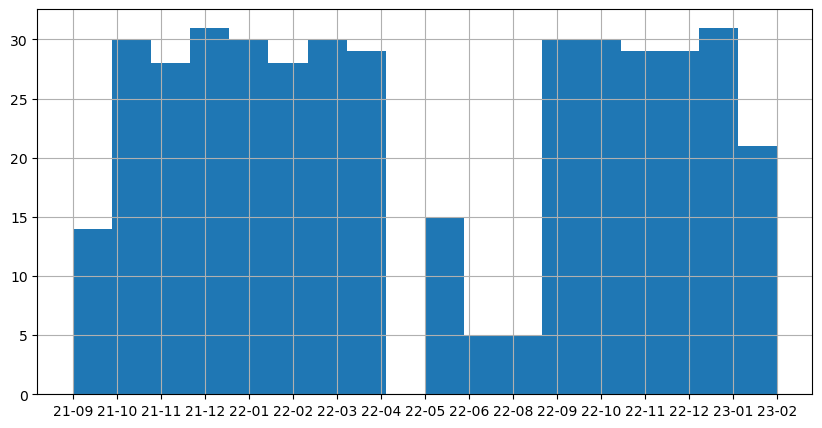

21-09: 3.37%
21-10: 7.23%
21-11: 6.75%
21-12: 7.47%
22-01: 7.23%
22-02: 6.75%
22-03: 7.23%
22-04: 6.99%
22-05: 3.61%
22-06: 1.20%
22-08: 1.20%
22-09: 7.23%
22-10: 7.23%
22-11: 6.99%
22-12: 6.99%
23-01: 7.47%
23-02: 5.06%


In [36]:
# the distribution of dates in the full dataset:
plt.figure(figsize=(10, 5))
plt.hist(get_month(np.arange(0, len(shifted_full.index))), bins=18)
plt.grid()
plt.show()

months_list = get_month(np.arange(0, len(shifted_full.index)))

# Count the occurrences of each month
month_counts = Counter(months_list)

# Calculate the total number of months
total_months = len(months_list)

# Print the proportion of each month
month_props = []
months = []
for month, count in month_counts.items():
    proportion = count / total_months
    month_props.append(proportion)
    months.append(month)
    print(f"{month}: {proportion:.2%}")


Beginning 5-fold cross validation

Fold 1
[  0   6  14  15  20  31  37  41  59  62  70  74  82  86  88  98 109 110
 117 121 123 133 142 143 146 147 152 156 158 160 161 168 169 171 176 178
 180 182 187 191 197 200 202 207 215 218 220 232 236 246 249 252 256 261
 265 271 272 273 276 282 284 285 304 305 312 318 319 322 323 324 342 367
 368 376 389 390 398 400 402 403 404 406 408]


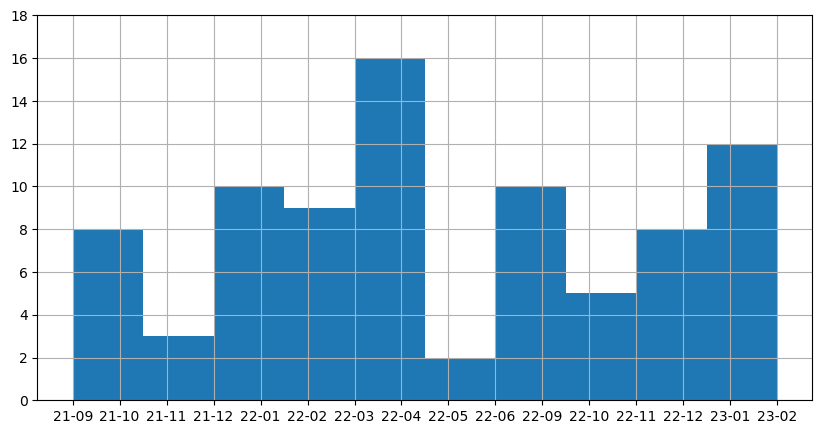

Fold 2
[  2   4   7  13  17  27  28  29  34  38  40  46  48  55  61  64  65  71
  72  78  89  92 101 103 112 134 139 140 144 145 149 155 157 162 165 166
 174 185 188 190 195 196 216 217 230 234 238 242 247 251 264 269 275 288
 289 291 292 300 301 302 306 313 325 327 328 335 336 337 344 345 346 348
 353 361 369 373 380 385 386 392 396 397 401]


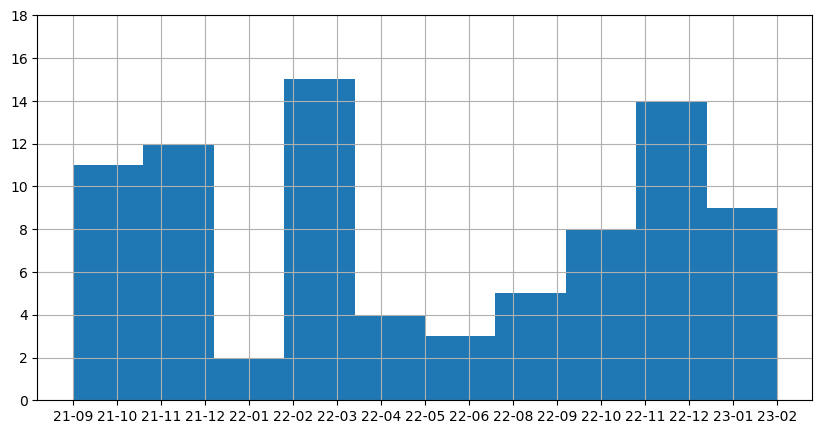

Fold 3
[  1   3   5  21  22  23  24  32  33  49  54  56  57  67  73  83  84  85
  90  93  96 100 105 107 113 115 116 124 126 127 130 131 136 141 148 154
 170 175 179 183 194 201 203 204 211 222 225 229 233 237 239 253 255 258
 274 279 281 293 297 298 303 307 314 317 332 341 349 351 355 356 358 362
 364 366 370 371 372 374 379 381 387 395 409]


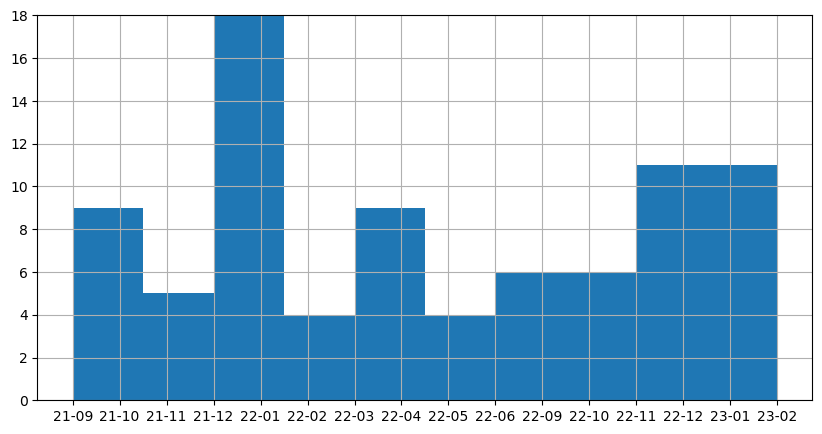

Fold 4
[  9  10  16  18  19  25  26  30  35  43  50  60  63  66  75  76  77  79
  87  91  95  97 106 114 122 125 129 137 150 151 159 164 172 177 186 193
 199 206 208 210 221 227 228 231 235 240 241 244 245 250 254 257 260 270
 277 278 280 287 290 295 296 299 310 315 316 321 326 331 333 343 352 354
 357 360 363 375 382 391 393 405 412 413 414]


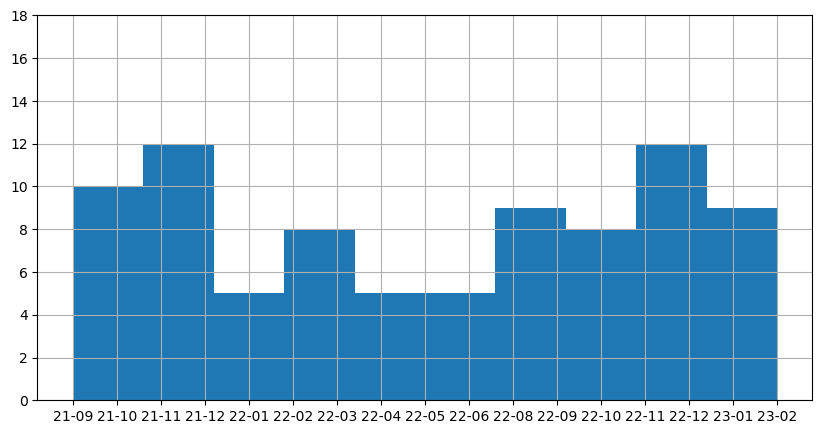

Fold 5
[  8  11  12  36  39  42  44  45  47  51  52  53  58  68  69  80  81  94
  99 102 104 108 111 118 119 120 128 132 135 138 153 163 167 173 181 184
 189 192 198 205 209 212 213 214 219 223 224 226 243 248 259 262 263 266
 267 268 283 286 294 308 309 311 320 329 330 334 338 339 340 347 350 359
 365 377 378 383 384 388 394 399 407 410 411]


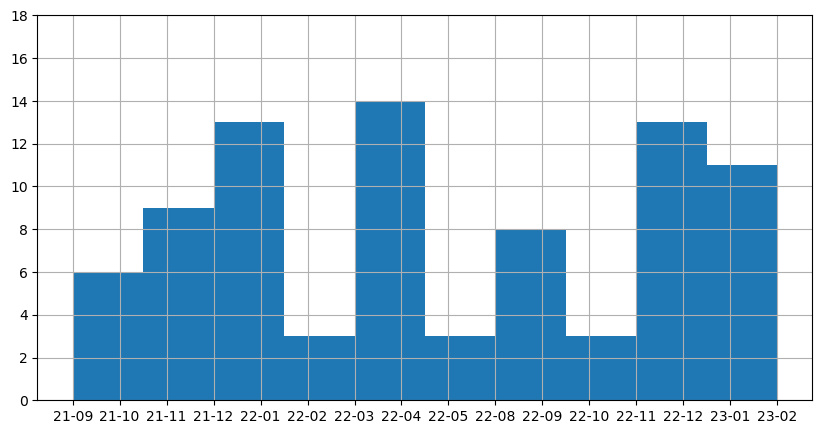

Finished 5-fold cross validation

median absolute deviation: 1.0461879334447293


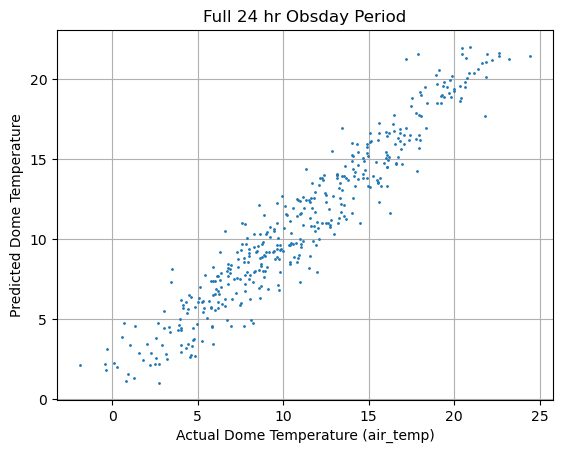

In [36]:
shifted_df = shifted_full
X = np.column_stack([shifted_df[features].values])
y = np.column_stack([shifted_df['air_temp_nextday']])
y = np.ravel(y)

# Split the training and testing set 50/50
idx_train, idx_test = train_test_split(np.arange(len(shifted_df)), test_size=0.5, random_state=6123)
# Define the random forest regressor
regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
print('Beginning 5-fold cross validation\n')

# With 5-fold cross validation
n_folds = 5
#kf creates the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
pred = np.zeros(len(X))

for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    pred[idx_test] = regrf.predict(X[idx_test])
    
    print(idx_test)
    plt.figure(figsize=(10, 5))
    plt.hist(get_month(idx_test.tolist()))
    plt.ylim(0, 18)
    plt.grid()
    plt.show()
    
print('Finished 5-fold cross validation\n')

predictions = pred
actual = y

plt.plot(actual, predictions, '.', ms=2)
plt.grid()
plt.ylabel('Predicted Dome Temperature')
plt.xlabel('Actual Dome Temperature (air_temp)')
plt.title('Full 24 hr Obsday Period')
print('median absolute deviation:', np.median(np.abs((predictions - actual))))

# Feature importance based on mean decrease in impurity

In [ ]:
importances = regrf.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Feature importance based on feature permutation

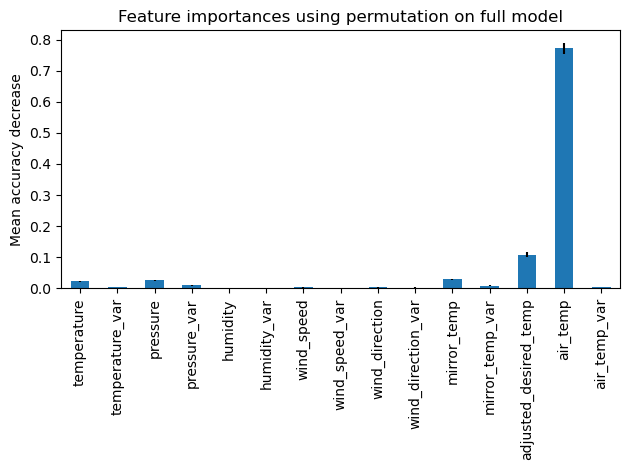

In [17]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    regrf, X, y, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Only Nights

Beginning 5-fold cross validation

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Finished 5-fold cross validation

median absolute deviation: 1.2209123750640813


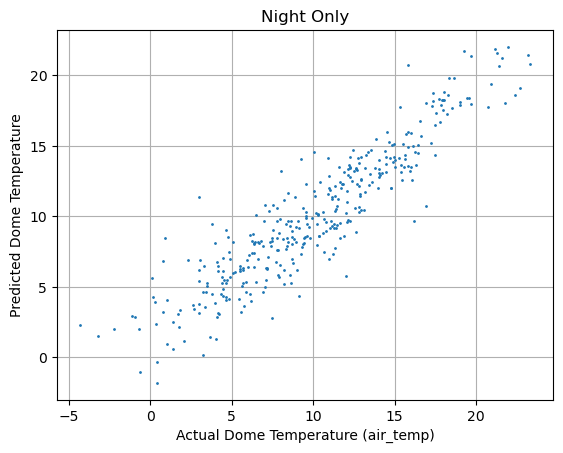

In [18]:
shifted_df = shifted_night
X = np.column_stack([shifted_df[features].values])
y = np.column_stack([shifted_df['air_temp_nextday']])
y = np.ravel(y)

# Split the training and testing set 50/50
idx_train, idx_test = train_test_split(np.arange(len(shifted_df)), test_size=0.5, random_state=6123)
# Define the random forest regressor
regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
print('Beginning 5-fold cross validation\n')

# With 5-fold cross validation
n_folds = 5
#kf creates the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
pred = np.zeros(len(X))
for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    pred[idx_test] = regrf.predict(X[idx_test])
print('Finished 5-fold cross validation\n')

predictions = pred
actual = y

plt.plot(actual, predictions, '.', ms=2)
plt.grid()
plt.ylabel('Predicted Dome Temperature')
plt.xlabel('Actual Dome Temperature (air_temp)')
plt.title('Night Only')
print('median absolute deviation:', np.median(np.abs((predictions - actual))))

# Feature importance based on mean decrease in impurity

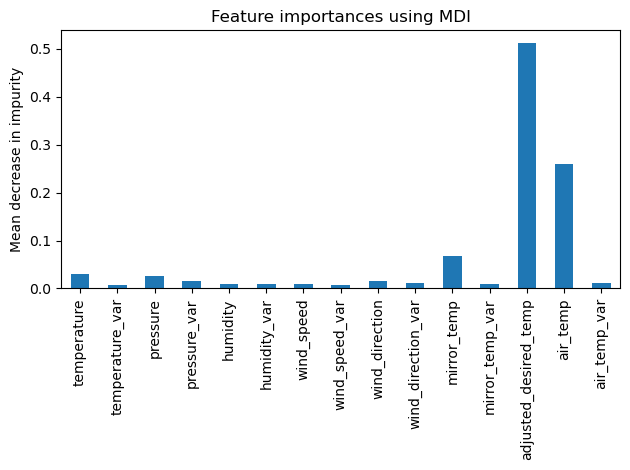

In [19]:
importances = regrf.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Feature importance based on feature permutation

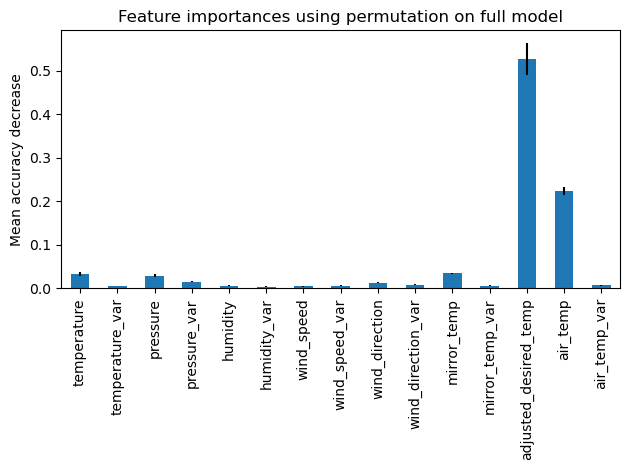

In [20]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    regrf, X, y, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()